In [1]:
import os

# Directory path
directory = '/kaggle/input/palm-yolo'

# Loop through all files in the directory
for filename in os.listdir(directory):
    print(filename)


Boumajhoul
Boufagous2
Kholt
Annotations
Boufagous
bouisthami
Boumajhoul2
Boufagous3


In [2]:
import os
import pandas as pd

# Input directory paths
input_directory = '/kaggle/input/palm-yolo'
annotations_directory = '/kaggle/input/palm-yolo/Annotations/Annotations/object detection/date fruits varieties'

# Paths to maturity classification .txt files
maturity_train_path = '/kaggle/input/palm-yolo/Annotations/Annotations/classification/maturity-train.txt'
maturity_test_path = '/kaggle/input/palm-yolo/Annotations/Annotations/classification/maturity-test.txt'

# Function to create a mapping from image filenames to maturity stages
def create_stage_mapping(file_paths):
    mapping = {}
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    # Split line into image path and stage label, handling spaces in paths
                    image_path_label = line.rsplit(' ', 1)
                    if len(image_path_label) == 2:
                        image_path, stage_label = image_path_label
                        # Normalize the path to use forward slashes
                        image_path = image_path.replace('\\', '/')
                        # Get the filename
                        image_filename = os.path.basename(image_path)
                        # Map the filename to stage label
                        mapping[image_filename] = stage_label
                    else:
                        print(f"Warning: Could not parse line: {line}")
    return mapping

# Create mapping for maturity stages
maturity_files = [maturity_train_path, maturity_test_path]
stage_mapping = create_stage_mapping(maturity_files)

# Folders to include
folders_to_include = [
    "Boufagous",
    "Boufagous2",
    "Boufagous3",
    "Boumajhoul",
    "Boumajhoul2",
    "Kholt",
    "bouisthami"
]

# List to store data for DataFrame
data = []

# Iterate over each main folder
for folder in folders_to_include:
    folder_path = os.path.join(input_directory, folder)
    if os.path.exists(folder_path):
        # Iterate over subfolders within the main folder
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                # Iterate over deeper subfolders
                for deeper_subfolder in os.listdir(subfolder_path):
                    deeper_subfolder_path = os.path.join(subfolder_path, deeper_subfolder)
                    if os.path.isdir(deeper_subfolder_path):
                        # Iterate over image files in the deeper subfolder
                        for filename in os.listdir(deeper_subfolder_path):
                            if filename.endswith('.jpg'):
                                file_path = os.path.join(deeper_subfolder_path, filename)
                                if os.path.isfile(file_path):
                                    # Map the label to the unified name
                                    if folder in ["Boufagous2", "Boufagous3"]:
                                        label = "Boufagous"
                                    elif folder == "Boumajhoul2":
                                        label = "Boumajhoul"
                                    else:
                                        label = folder

                                    # Find corresponding annotation file
                                    annotation_filename = filename.replace('.jpg', '.txt')
                                    annotation_file_path = os.path.join(annotations_directory, annotation_filename)

                                    # Initialize bounding box list
                                    bounding_boxes = []

                                    # Check if annotation file exists
                                    if os.path.exists(annotation_file_path):
                                        with open(annotation_file_path, 'r') as annotation_file:
                                            for line in annotation_file:
                                                parts = line.strip().split()
                                                if len(parts) >= 5:
                                                    x_min = float(parts[1])
                                                    y_min = float(parts[2])
                                                    x_max = float(parts[3])
                                                    y_max = float(parts[4])
                                                    bounding_boxes.append((x_min, y_min, x_max, y_max))

                                    # Get the stage for this image
                                    stage = stage_mapping.get(filename)
                                    if not stage:
                                        print(f"Warning: Image '{filename}' not found in stage mapping. Skipping.")
                                        continue  # Skip images without a stage

                                    # Add entry for the DataFrame
                                    data.append([file_path, label, bounding_boxes, stage])

# Create a DataFrame using the collected data
df = pd.DataFrame(data, columns=['FilePath', 'Label', 'BoundingBoxes', 'Stage'])

# Create CSV file in the working directory
csv_file_path = '/kaggle/working/images_with_labels.csv'
df.to_csv(csv_file_path, index=False)

print(f"CSV file has been successfully created at: {csv_file_path}")

CSV file has been successfully created at: /kaggle/working/images_with_labels.csv


In [3]:
print(df.head())

                                            FilePath      Label  \
0  /kaggle/input/palm-yolo/Boufagous/Boufagous/S1...  Boufagous   
1  /kaggle/input/palm-yolo/Boufagous/Boufagous/S1...  Boufagous   
2  /kaggle/input/palm-yolo/Boufagous/Boufagous/S1...  Boufagous   
3  /kaggle/input/palm-yolo/Boufagous/Boufagous/S1...  Boufagous   
4  /kaggle/input/palm-yolo/Boufagous/Boufagous/S1...  Boufagous   

                                       BoundingBoxes     Stage  
0  [(0.43711412, 0.51238847, 0.35040033, 0.263127...  Immature  
1  [(0.500249, 0.490431, 0.999501, 0.59375), (0.2...  Immature  
2  [(0.565304, 0.471899, 0.519442, 0.227713), (0....  Immature  
3  [(0.64947385, 0.42202, 0.4300368, 0.1996086), ...  Immature  
4  [(0.15329, 0.514293, 0.305583, 0.15407), (0.73...  Immature  


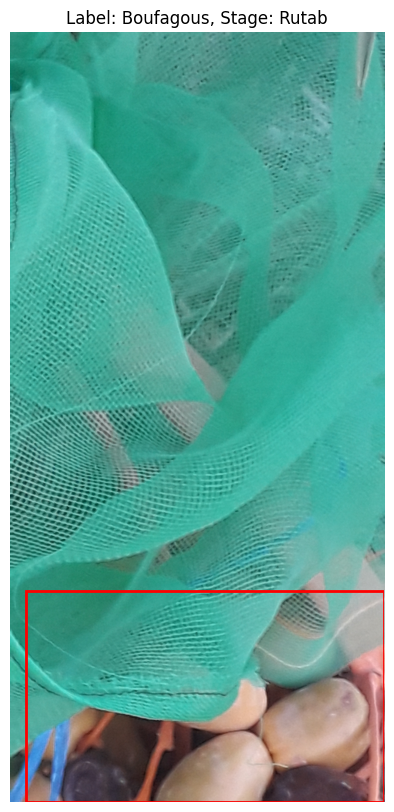

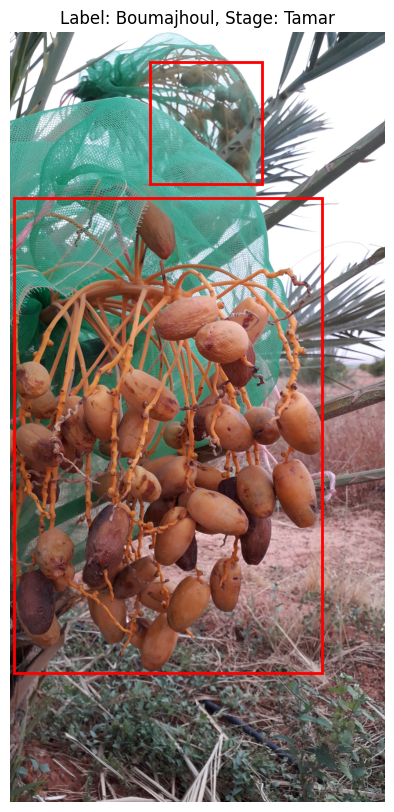

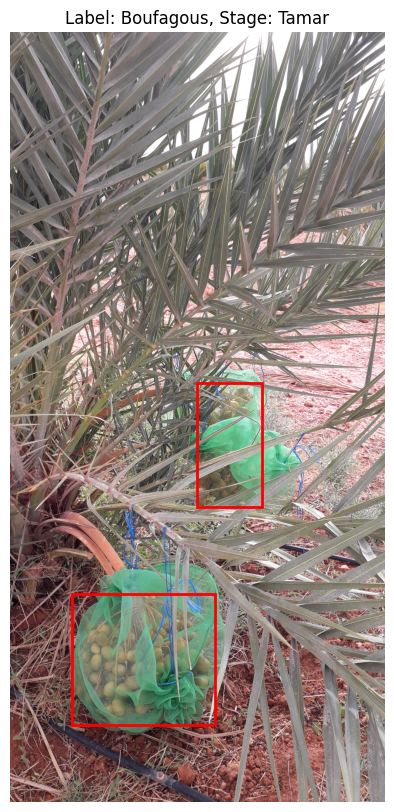

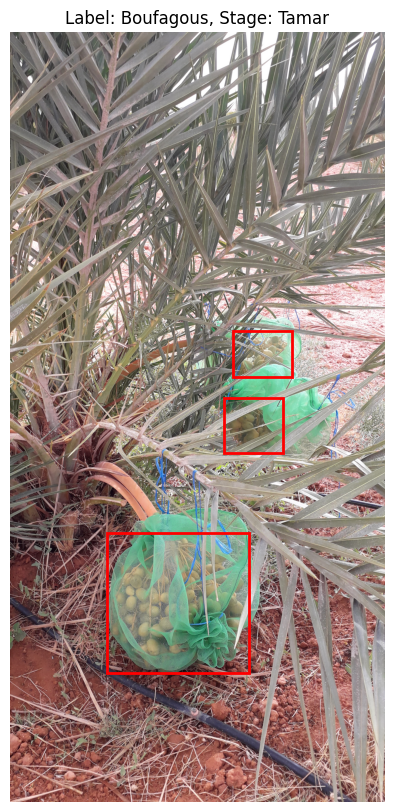

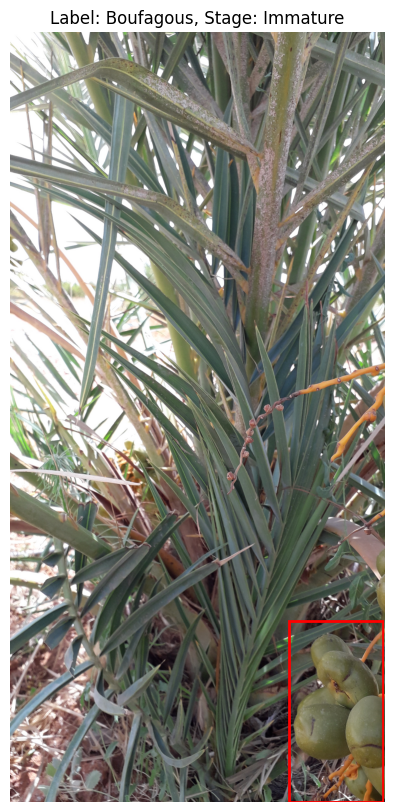

In [4]:
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import ast

# Load the CSV file into a DataFrame
csv_file_path = '/kaggle/working/images_with_labels.csv'
df = pd.read_csv(csv_file_path)

# Select 5 random rows from the DataFrame
random_rows = df.sample(n=5)

# Loop over the selected rows
for idx, random_row in random_rows.iterrows():
    # Extract data from the selected row
    image_path = random_row['FilePath']
    label = random_row['Label']
    stage = random_row['Stage']
    bounding_boxes = ast.literal_eval(random_row['BoundingBoxes'])  # Convert string representation to list of tuples

    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image at path: {image_path}")
        continue  # Skip to the next image
    else:
        # Convert BGR to RGB for proper display in matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Plot the image using matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Label: {label}, Stage: {stage}")

        # Draw bounding boxes
        img_height, img_width, _ = image.shape
        for box in bounding_boxes:
            # YOLO bounding boxes are represented as (x_center, y_center, width, height)
            x_center, y_center, width, height = box

            # Convert from normalized coordinates to pixel coordinates
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)

            # Ensure coordinates are within image bounds
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(img_width, x_max)
            y_max = min(img_height, y_max)

            # Draw the rectangle on the image
            plt.gca().add_patch(
                plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                              linewidth=2, edgecolor='red', facecolor='none')
            )

        plt.axis('off')
        plt.show()

In [5]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.4/881.4 kB 22.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import os
import shutil
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from ast import literal_eval
from ultralytics import YOLO

# Load the dataset
csv_path = "/kaggle/working/images_with_labels.csv"
data = pd.read_csv(csv_path)

# Step 1: Take only 25% of the data to reduce size
data_sampled = data.sample(frac=0.25, random_state=42)

# Step 2: Data Cleaning
def is_valid_bbox(bbox):
    return isinstance(bbox, str) and len(bbox) > 2  # Checking for non-empty list representation

valid_labels = data_sampled['Label'].unique().tolist()
valid_stages = data_sampled['Stage'].unique().tolist()

# Filter rows with valid bounding boxes, labels, and stages
data_cleaned = data_sampled[
    data_sampled['BoundingBoxes'].apply(is_valid_bbox) &
    data_sampled['Label'].isin(valid_labels) &
    data_sampled['Stage'].isin(valid_stages)
]

# Step 3: Filter Images That Exist
data_cleaned = data_cleaned[data_cleaned['FilePath'].apply(os.path.exists)]

# Step 4: Copy Images to Writable Directories and Verify They Are Valid
def copy_images(data, dest_folder):
    copied_data = []
    for _, row in data.iterrows():
        image_path = row['FilePath']
        image_name = os.path.basename(image_path)
        destination_path = os.path.join(dest_folder, image_name)
        if not os.path.exists(destination_path):
            try:
                # Verify if the image can be opened
                with Image.open(image_path) as img:
                    img.verify()  # Verify that the image is not corrupt
                shutil.copy(image_path, destination_path)  # Copy the image if it is valid
                copied_data.append(row)  # Keep track of successfully copied data
            except (UnidentifiedImageError, IOError) as e:
                print(f"Skipping corrupt or unreadable image: {image_path} - {e}")
    return pd.DataFrame(copied_data)

# Create a directory for all valid images
os.makedirs("/kaggle/working/yolo_data/images/all", exist_ok=True)

# Copy all images to a writable directory and collect the valid rows
all_data_copied = copy_images(data_cleaned, "/kaggle/working/yolo_data/images/all")

# Step 5: Re-split the Copied Data into Train and Validation Sets
train_data, val_data = train_test_split(all_data_copied, test_size=0.2, random_state=42)

# Create directories for train and validation images
os.makedirs("/kaggle/working/yolo_data/images/train", exist_ok=True)
os.makedirs("/kaggle/working/yolo_data/images/val", exist_ok=True)

# Move images to train and validation folders
def move_images(data, src_folder, dest_folder):
    for _, row in data.iterrows():
        image_name = os.path.basename(row['FilePath'])
        src_path = os.path.join(src_folder, image_name)
        dest_path = os.path.join(dest_folder, image_name)
        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)

move_images(train_data, "/kaggle/working/yolo_data/images/all", "/kaggle/working/yolo_data/images/train")
move_images(val_data, "/kaggle/working/yolo_data/images/all", "/kaggle/working/yolo_data/images/val")

# Display the count of each stage and label in the training and validation data
print("Stage Counts in Training Data:")
print(train_data['Stage'].value_counts())
print("\nLabel Counts in Training Data:")
print(train_data['Label'].value_counts())

print("\nStage Counts in Validation Data:")
print(val_data['Stage'].value_counts())
print("\nLabel Counts in Validation Data:")
print(val_data['Label'].value_counts())

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Stage Counts in Training Data:
Stage
Rutab       649
Tamar       455
Khalal      282
Immature    247
Name: count, dtype: int64

Label Counts in Training Data:
Label
Boufagous     810
Boumajhoul    484
Kholt         339
Name: count, dtype: int64

Stage Counts in Validation Data:
Stage
Rutab       180
Tamar        94
Khalal       76
Immature     59
Name: count, dtype: int64

Label Counts in Validation Data:
Label
Boufagous     189
Boumajhoul    118
Kholt         102
Name: count, dtype: int64


In [7]:

# Create directories for labels (annotations)
os.makedirs("/kaggle/working/yolo_data/labels/train", exist_ok=True)
os.makedirs("/kaggle/working/yolo_data/labels/val", exist_ok=True)

corrupt_count = 0

def convert_bbox_yolo_format(bbox):
    # Extract bounding box coordinates
    x1, y1, x2, y2 = bbox

    # Auto-fix incorrect bounding box coordinates
    if x1 > x2:
        x1, x2 = x2, x1
    if y1 > y2:
        y1, y2 = y2, y1

    # Validate the bounding box coordinates after correction
    if not (0 <= x1 < x2 <= 1) or not (0 <= y1 < y2 <= 1):
        print(f"Invalid bounding box coordinates after correction: {bbox} - x2 must be greater than x1 and y2 must be greater than y1, within range [0, 1]")
        return None  # Return None if values are out of bounds even after correction

    # Convert to YOLO format (x_center, y_center, width, height), normalized
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0
    width = x2 - x1
    height = y2 - y1

    # Set a lower minimum threshold for valid bounding box dimensions to allow smaller boxes
    min_size = 0.00001
    if width < min_size or height < min_size:
        return None

    return x_center, y_center, width, height

def save_annotations(data, label_folder):
    global corrupt_count

    for _, row in data.iterrows():
        image_path = row['FilePath']
        label = row['Stage']
        bboxes = literal_eval(row['BoundingBoxes'])  # Use literal_eval for safer parsing

        # Skip if the image file does not exist
        if not os.path.exists(image_path):
            continue

        # Create label file path (same name as image but with .txt extension)
        image_name = os.path.basename(image_path)
        label_file_path = os.path.join(label_folder, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

        with open(label_file_path, 'w') as f:
            valid_boxes = 0
            for bbox in bboxes:
                # Convert bbox to YOLO format using the normalized values directly
                yolo_bbox = convert_bbox_yolo_format(bbox)
                if yolo_bbox:
                    class_id = valid_stages.index(label)  # Get class ID for the label
                    f.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")
                    valid_boxes += 1
                else:
                    corrupt_count += 1

            # If no valid boxes were written, remove the label file
            if valid_boxes == 0:
                f.close()
                os.remove(label_file_path)

# Save training and validation annotations without moving images
save_annotations(train_data, "/kaggle/working/yolo_data/labels/train")
save_annotations(val_data, "/kaggle/working/yolo_data/labels/val")

# Print the number of corrupt bounding boxes
print(f"Number of corrupt bounding boxes: {corrupt_count}")

# Step 6: Create a YAML configuration for YOLOv8 training
yaml_content = f"""
train: /kaggle/working/yolo_data/images/train
val: /kaggle/working/yolo_data/images/val

nc: {len(valid_stages)}
names: {valid_stages}
"""

# Save the YAML file
yaml_path = "/kaggle/working/yolo_data/data.yaml"
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)


Invalid bounding box coordinates after correction: (0.49909747, 0.50768816, 1.0205181, 1.1436719) - x2 must be greater than x1 and y2 must be greater than y1, within range [0, 1]
Invalid bounding box coordinates after correction: (0.299103, 0.714147, 0.299103, 0.122093) - x2 must be greater than x1 and y2 must be greater than y1, within range [0, 1]
Invalid bounding box coordinates after correction: (0.50293136, 0.5675249, 1.0064739, 0.9571676) - x2 must be greater than x1 and y2 must be greater than y1, within range [0, 1]
Invalid bounding box coordinates after correction: (0.5039089, 0.42887008, 1.0732715, 0.8523972) - x2 must be greater than x1 and y2 must be greater than y1, within range [0, 1]
Invalid bounding box coordinates after correction: (0.50054234, 0.49691853, 1.0402651, 0.59683025) - x2 must be greater than x1 and y2 must be greater than y1, within range [0, 1]
Invalid bounding box coordinates after correction: (0.50095177, 0.65807825, 1.1228728, 0.6809645) - x2 must be g

In [8]:
# Step 7: Train YOLOv8 Model
model = YOLO('yolov8n.pt')  # Load a pre-trained YOLOv8 model (e.g., yolov8n.pt)
model.train(data=yaml_path, epochs=20, imgsz=640, device='0')  # Use GPU if available

# Step 8: Save the Trained Model
model.save("/kaggle/working/yolo8_trained_model.pt")

# Print message indicating completion
print("YOLOv8 model training completed and saved.")
#api is 'd83758bf62b88cffdffa38be8d97196d0a9c4f7c'

100%|██████████| 6.25M/6.25M [00:00<00:00, 79.3MB/s]


Ultralytics 8.3.3 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_data/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 22.7MB/s]
2024-10-02 19:10:45,705	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-02 19:10:46,241	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 79.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_data/labels/train... 1626 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1633/1633 [02:45<00:00,  9.84it/s]

train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_180927.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_181026.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_181054.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_181124.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_181133.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_181157.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_181209.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_181226.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo_data/images/train/20220725_181230.jpg: corrupt JPEG restored and saved
train: WAR

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_data/labels/val... 408 images, 1 backgrounds, 0 corrupt: 100%|██████████| 409/409 [00:49<00:00,  8.26it/s]

val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220725_181015.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220725_181140.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220725_181218.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220725_181317.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220725_181413.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220725_181612.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220725_181741.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220725_181746.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/images/val/20220726_173653.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/yolo_data/imag

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.38G      3.069       4.53      2.688          3        640: 100%|██████████| 103/103 [01:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]

                   all        409        644    0.00209       0.38    0.00796    0.00214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.33G      2.711       4.05      2.316          1        640: 100%|██████████| 103/103 [01:48<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]


                   all        409        644      0.262     0.0554    0.00693    0.00192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.33G      2.644      3.823       2.31          3        640: 100%|██████████| 103/103 [01:54<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]

                   all        409        644      0.554     0.0322     0.0112    0.00331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.33G      2.584      3.703      2.277          2        640: 100%|██████████| 103/103 [01:47<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.36s/it]

                   all        409        644      0.294     0.0431     0.0146    0.00435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.32G      2.475      3.583        2.2          0        640: 100%|██████████| 103/103 [01:50<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:16<00:00,  1.31s/it]

                   all        409        644      0.572     0.0369     0.0292     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.34G      2.431      3.443      2.146          2        640: 100%|██████████| 103/103 [01:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]

                   all        409        644      0.306     0.0941     0.0406     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.35G      2.368      3.379      2.114          2        640: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]

                   all        409        644      0.338     0.0725     0.0537     0.0202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.33G      2.311      3.262      2.071          4        640: 100%|██████████| 103/103 [01:48<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]

                   all        409        644       0.13     0.0719      0.051     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.33G      2.257      3.157       2.05          1        640: 100%|██████████| 103/103 [01:51<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.31s/it]

                   all        409        644      0.171       0.15     0.0812     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.34G      2.235      3.085      1.997          2        640: 100%|██████████| 103/103 [01:50<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.36s/it]

                   all        409        644       0.15      0.155      0.077      0.029


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.31G      2.283      3.194      2.097          2        640: 100%|██████████| 103/103 [02:01<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]

                   all        409        644      0.184       0.14     0.0841     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.32G      2.236      2.979      2.043          2        640: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]

                   all        409        644      0.162      0.152     0.0921     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.32G      2.201      2.903      2.003          2        640: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:16<00:00,  1.29s/it]

                   all        409        644      0.208       0.19      0.104     0.0439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.32G      2.148      2.804      1.954          1        640: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]

                   all        409        644      0.224      0.219      0.129     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.31G      2.119      2.762      1.911          1        640: 100%|██████████| 103/103 [01:46<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]

                   all        409        644      0.207      0.243      0.117      0.051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.32G      2.062      2.698      1.876          3        640: 100%|██████████| 103/103 [01:48<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.36s/it]

                   all        409        644      0.178      0.226      0.117     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.32G      2.037      2.658      1.859          1        640: 100%|██████████| 103/103 [01:48<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]

                   all        409        644      0.177      0.221      0.116      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.32G      2.019      2.622      1.848          3        640: 100%|██████████| 103/103 [01:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]

                   all        409        644      0.234      0.258       0.15     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.31G      1.983      2.576      1.816          1        640: 100%|██████████| 103/103 [01:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:16<00:00,  1.30s/it]

                   all        409        644      0.235      0.278      0.146     0.0686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.32G       1.94      2.537      1.792          2        640: 100%|██████████| 103/103 [01:49<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]

                   all        409        644      0.211      0.258      0.135     0.0641



20 epochs completed in 0.717 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.3 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 186 layers, 2,685,148 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


                   all        409        644      0.234      0.258       0.15     0.0693
              Immature         58        109      0.205      0.229      0.126     0.0447
                 Rutab        180        265      0.287      0.317      0.217      0.103
                Khalal         76        129       0.27      0.202      0.142     0.0668
                 Tamar         94        141      0.174      0.284      0.114     0.0629
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


YOLOv8 model training completed and saved.
